In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

loadhou = pd.read_csv('/content/drive/MyDrive/MAR6669-data/loadhou.csv')

In [33]:
loadhou

,Time,KHOU,COAST
0,1/1/10 15:00,7.10,8222.029420
1,1/2/10 15:00,9.10,8379.872342
2,1/3/10 15:00,6.10,8679.087157
3,1/4/10 15:00,4.10,10273.567000
4,1/5/10 15:00,3.10,10317.801170
...,...,...,...
2352,6/26/16 15:00,31.60,16588.555300
2353,6/27/16 15:00,31.60,18056.292190
2354,6/28/16 15:00,31.60,16908.966850
2355,6/29/16 15:00,29.35,17397.014410


In [34]:
# train-validation-test split
np.random.seed(123)  # set the random seed for reproducibility

N = loadhou.shape[0]
# 70/20/10 split    
train_ind, val_ind, test_ind = np.split(np.random.permutation(N), [int(.7*N), int(.9*N)])
D_train = loadhou.loc[train_ind, :]
D_valid = loadhou.loc[val_ind, :]
D_test = loadhou.loc[test_ind, :]

In [35]:
X_train = D_train['KHOU'].values[:,None]
y_train = D_train['COAST'].values

X_valid = D_valid['KHOU'].values[:,None]
y_valid = D_valid['COAST'].values

### Fit a linear model as baseline

In [36]:
import statsmodels.api as sm
lm1 = sm.OLS(y_train, X_train).fit()

y_pred = lm1.predict(X_valid)

lm1_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(lm1_rmse)

2544.686210324086


### Train the KNN model and calculate RMSE on the validation set

In [37]:
# Try K=25
from sklearn.neighbors import KNeighborsRegressor
np.random.seed(123) 

knn_model = KNeighborsRegressor(n_neighbors=25)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_valid)

knn_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(knn_rmse)

1000.1630689415206


### KNN  check performance across a variety of choices for K

In [38]:
k_grid = np.unique(np.round(np.exp(np.linspace(np.log(1500), np.log(2), num=100))))
k_grid = [int(_) for _ in k_grid]
print(k_grid)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 27, 29, 31, 33, 35, 38, 41, 43, 46, 50, 53, 57, 61, 65, 69, 74, 79, 85, 90, 97, 103, 111, 118, 126, 135, 144, 154, 165, 177, 189, 202, 216, 231, 247, 264, 282, 301, 322, 344, 368, 394, 421, 450, 481, 515, 550, 588, 629, 672, 719, 769, 822, 879, 939, 1004, 1074, 1148, 1227, 1312, 1403, 1500]


In [39]:
# Try all K
rmse_grid_out = []
for k in k_grid:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_grid_out.append(rmse)

rmse_grid_out = pd.DataFrame({'K': k_grid, 'RMSE': rmse_grid_out})


In [40]:
ind_best = np.argmin(rmse_grid_out['RMSE'])
k_best = k_grid[ind_best]

In [41]:
k_best

11

In [42]:
rmse_grid_out.head()

,K,RMSE
0,2,1078.363105
1,3,1073.893883
2,4,1037.097883
3,5,1022.369458
4,6,1012.109350


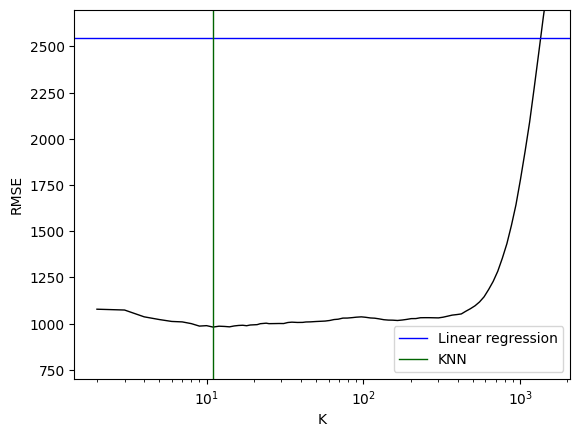

In [43]:
plt.figure()
plt.plot(rmse_grid_out['K'], rmse_grid_out['RMSE'], linewidth=1, color='black')
plt.xscale('log')
plt.ylim(700, 2700)
plt.axhline(y=lm1_rmse, color='blue', linewidth=1, label='Linear regression')
plt.axvline(x=k_best, color='darkgreen', linewidth=1, label='KNN')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### K-nearest neighbors: at the optimal k 

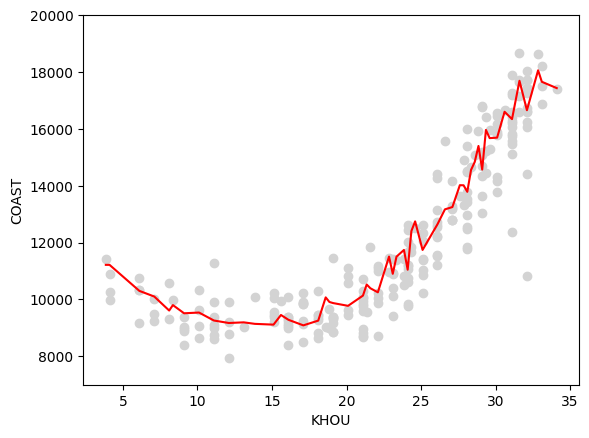

In [44]:
knn_model = KNeighborsRegressor(n_neighbors=k_best)
knn_model.fit(X_train, y_train)

D_test = D_test.sort_values(by='KHOU') # for better plotting
X_test, y_test = D_test['KHOU'].values[:,None], D_test['COAST'].values

y_pred = knn_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred))

D_test['ypred'] = y_pred

plt.figure()
plt.scatter(D_test['KHOU'], D_test['COAST'], color='lightgrey')
plt.plot(D_test['KHOU'], D_test['ypred'], color='red', linewidth=1.5)
plt.ylim(7000, 20000)
plt.xlabel('KHOU')
plt.ylabel('COAST')
plt.show()